In [1]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

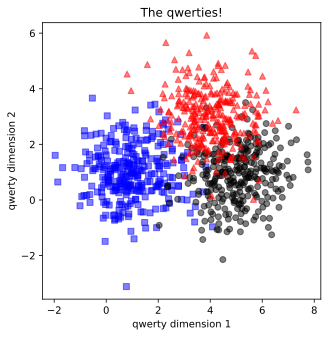

In [2]:
# create data

nPerClust = 300
blur = 1

A = [ 1, 1 ]
B = [ 5, 1 ]
C = [ 4, 3 ]

# generate data
a = [ A[0]+np.random.randn(nPerClust)*blur , A[1]+np.random.randn(nPerClust)*blur ]
b = [ B[0]+np.random.randn(nPerClust)*blur , B[1]+np.random.randn(nPerClust)*blur ]
c = [ C[0]+np.random.randn(nPerClust)*blur , C[1]+np.random.randn(nPerClust)*blur ]

# true labels
labels_np = np.hstack((  np.zeros((nPerClust)),
                         np.ones( (nPerClust)),
                       1+np.ones( (nPerClust))  ))

# concatanate into a matrix
data_np = np.hstack((a,b,c)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long() # note: "long" format for CCE

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs',alpha=.5)
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko',alpha=.5)
plt.plot(data[np.where(labels==2)[0],0],data[np.where(labels==2)[0],1],'r^',alpha=.5)
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [3]:
train_x, test_x, train_y, test_y = train_test_split(data, labels, train_size=0.9)

train_data = TensorDataset(train_x, train_y)
test_data = TensorDataset(test_x, test_y)

train_dl = DataLoader(train_data, batch_size=16, shuffle=True, drop_last=True)
test_dl = DataLoader(test_data, batch_size=test_data.__len__())

In [4]:
class model(nn.Module):
    def __init__(self):
        super().__init__()

        self.input = nn.Linear(2, 8)
        self.hidden = nn.Linear(8,8)
        self.output = nn.Linear(8,3)

    def forward(self, data):
        x = F.relu(self.input(data))
        x = F.relu(self.hidden(x))
        x = self.output(x)

        return x


In [8]:
def getModel(optimizerType, lr):
    ANN = model()

    lossFunction = nn.CrossEntropyLoss()
    optimFun = getattr(torch.optim, optimizerType)
    optimizer = optimFun(params=ANN.parameters(), lr=lr)

    return ANN, lossFunction, optimizer

In [15]:
epochs = 50

def trainModel(ANN, lossFunction, optimizer):
    losses = torch.zeros(epochs)
    trainAcc = []
    testAcc = []
    for _ in range(epochs):
        batchAcc = []
        batchLoss = []
        for x, y in train_dl:
            yHat = ANN.forward(x)

            loss = lossFunction(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())
            batchAcc.append(torch.mean((torch.argmax(yHat, axis=1) == y).float())*100)

        trainAcc.append(np.mean(batchAcc))
        losses[_] = np.mean(batchLoss)

        X, Y = next(iter(test_dl))
        with torch.no_grad():
            pred = ANN(X)
        
        testAcc.append(torch.mean((torch.argmax(pred, axis=1)==Y).float())*100)

    return trainAcc, testAcc, losses, ANN

In [17]:
learning_rates = np.logspace(-4, -1, 20)
optimType = ['SGD', 'RMSprop', 'Adam']

# results = np.zeros((epochs, len(momenta), 3))
# for i, momentum in enumerate(momenta):
#     ANN, lossFunction, optimizer = getModel(momentum)
#     trainingOutput = trainModel(ANN, lossFunction, optimizer)
#     results[:, i, 0] = trainingOutput[2] # losses
#     results[:, i, 1] = trainingOutput[0] # trainAcc
#     results[:, i, 2] = trainingOutput[1] # testAcc
finalTestAcc = np.zeros((len(learning_rates), len(optimType)))

for optimTypei in range(len(optimType)):
    print("optimizer: ", optimType[optimTypei])
    for _, lr in enumerate(learning_rates):
        print("lr: ", lr)
        ANN, lossFunction, optimizer = getModel(optimType[optimTypei], lr)
        trainAcc, testAcc, losses, ANN = trainModel(ANN, lossFunction, optimizer)

        finalTestAcc[_, optimTypei] = np.mean(testAcc[-10:])
        




optimizer:  SGD
lr:  0.0001
lr:  0.0001438449888287663
lr:  0.00020691380811147902
lr:  0.00029763514416313193
lr:  0.00042813323987193956
lr:  0.0006158482110660267
lr:  0.0008858667904100823
lr:  0.0012742749857031334
lr:  0.0018329807108324356
lr:  0.0026366508987303583
lr:  0.00379269019073225
lr:  0.005455594781168515
lr:  0.007847599703514606
lr:  0.011288378916846883
lr:  0.01623776739188721
lr:  0.023357214690901212
lr:  0.03359818286283781
lr:  0.04832930238571752
lr:  0.06951927961775606
lr:  0.1
optimizer:  RMSprop
lr:  0.0001
lr:  0.0001438449888287663
lr:  0.00020691380811147902
lr:  0.00029763514416313193
lr:  0.00042813323987193956
lr:  0.0006158482110660267
lr:  0.0008858667904100823
lr:  0.0012742749857031334
lr:  0.0018329807108324356
lr:  0.0026366508987303583
lr:  0.00379269019073225
lr:  0.005455594781168515
lr:  0.007847599703514606
lr:  0.011288378916846883
lr:  0.01623776739188721
lr:  0.023357214690901212
lr:  0.03359818286283781
lr:  0.04832930238571752
lr:  0

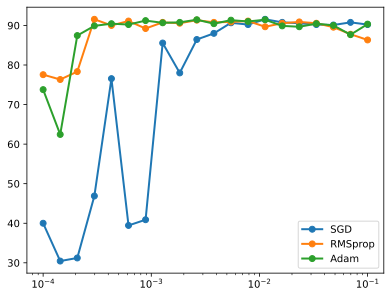

In [24]:
plt.plot(learning_rates, finalTestAcc, 'o-',linewidth=2)
plt.legend(optimType)
plt.xscale('log')
plt.show()

## The learning rates have very little effect over the RMS and Adam optimizers compared to the effect on SGD .i.e. because the learining rates are adjusted in the RMS and Adam according to the learning of previous epochs wherease learning rate is constant in case of SGD.